In [1]:
#%source bin/activate
import tensorflow as tf
import os
import skimage.io as io
import time
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
IMG_HEIGHT, IMG_WIDTH = 128, 128

# labels -- [iso, D, T, X, U, L]
NLBL = 2

rundir = "/home/walterms/project/walterms/mcmd/nn/cnn/data/mixed/"
trndir = rundir+"train/"
testdir = rundir+"test/"
unlbldir = rundir+"unlbl/"

trnsubset = ["edge15.tfrecords", "edge40.tfrecords"]
testsubset = ["edge15.tfrecords", "edge40.tfrecords"]
unlblsubset = [""]

testrecords, unlblrecords, trnrecords = [],[],[]

if trnsubset == [""]:
    trnrecords = [trndir+x for x in os.listdir(trndir)]
else:
    trnrecords = [trndir+x for x in trnsubset]
if testsubset == [""]:
    testrecords = [testdir+x for x in os.listdir(testdir)]
else:
    testrecords = [testdir+x for x in testsubset]
if unlblsubset == [""]:
    unlblrecords = [unlbldir+x for x in os.listdir(unlbldir)]
else:
    unlblrecords = [unlbldir+x for x in unlblsubset]

In [3]:
print "./data/edgevar/train/edge15.tfrecords"

./data/edgevar/train/edge15.tfrecords


In [4]:
print trnrecords, testrecords

['/home/walterms/project/walterms/mcmd/nn/cnn/data/mixed/train/edge15.tfrecords', '/home/walterms/project/walterms/mcmd/nn/cnn/data/mixed/train/edge40.tfrecords'] ['/home/walterms/project/walterms/mcmd/nn/cnn/data/mixed/test/edge15.tfrecords', '/home/walterms/project/walterms/mcmd/nn/cnn/data/mixed/test/edge40.tfrecords']


In [5]:
benchrecord = ["/home/walterms/project/walterms/mcmd/nn/cnn/data/benchmark/benchmark.tfrecords"]

In [6]:
def read_records(filename_queue, batchSize, labeled):
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    
    features = None
    if labeled == True:
        features = tf.parse_single_example(
          serialized_example,
          # Defaults are not specified since both keys are required.
          features={
            'height': tf.FixedLenFeature([], tf.int64),
            'width': tf.FixedLenFeature([], tf.int64),
            'image_raw': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.int64)
            })
    elif labeled == False:
        features = tf.parse_single_example(
          serialized_example,
          # Defaults are not specified since both keys are required.
          features={
            'height': tf.FixedLenFeature([], tf.int64),
            'width': tf.FixedLenFeature([], tf.int64),
            'image_raw': tf.FixedLenFeature([], tf.string)
            })
    else:
        print "Need to specify record type (labeled or not) for read_records"
        return

    # Convert from a scalar string tensor (whose single string has
    # length mnist.IMAGE_PIXELS) to a uint8 tensor with shape
    # [mnist.IMAGE_PIXELS].
    image = tf.decode_raw(features['image_raw'], tf.uint8)
#     height = tf.cast(features['height'], tf.int32)
#     width = tf.cast(features['width'], tf.int32)
    
    label = None
    blankvec = None
    if labeled == True:
        label = tf.cast(features['label'], tf.int32)
        v = [0 for i in range(NLBL)]
        blankvec = tf.Variable(v)    
    
    image_shape = tf.stack([IMG_HEIGHT,IMG_WIDTH])
    image_reshaped = tf.reshape(image, image_shape)
#     image_size_const = tf.constant((IMG_HEIGHT, IMG_WIDTH), dtype=tf.int32)
    
#     # Random transformations can be put here: right before you crop images
#     # to predefined size. To get more information look at the stackoverflow
#     # question linked above.
    
#     resized_image = tf.image.resize_image_with_crop_or_pad(image=image,
#                                            target_height=constHeight,
#                                            target_width=constWidth)
    
    if labeled == True:
        return image_reshaped, label, blankvec
    else:
        return image_reshaped

def shuffled_queue_join(Qlist, batchSize):
    return tf.train.shuffle_batch_join(Qlist,
                                        batch_size=batchSize,
                                        capacity=1000+3*batchSize,
                                        min_after_dequeue=1000)

In [39]:
# Divide by stride*stride for each conv layer
filterWidth = 15
stride = 8
conv1_nOut = 32
conv2_nOut = 64
fc1_nIn = IMG_HEIGHT*IMG_WIDTH*conv2_nOut/(stride*stride*stride*stride)
fc1_nOut = 512

trnBatchSize = 100
testSetSize = 200
eta = 1e-4
nTrnIter = 500
testStep = nTrnIter/20

beta = 1e-3


def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    s = stride
    return tf.nn.conv2d(x, W, strides=[1,s,s,1], padding='SAME')


x = tf.placeholder(tf.float32, shape=[None, IMG_HEIGHT, IMG_WIDTH])
x_norm = tf.scalar_mul(1./255.,x)
y_ = tf.placeholder(tf.float32, shape=[None, NLBL])

x_image = tf.reshape(x_norm, [-1, IMG_HEIGHT, IMG_WIDTH, 1])

W_conv1 = weight_variable([filterWidth, filterWidth, 1, conv1_nOut]) # [x,y,nInputChannel,nOutChannel]
b_conv1 = bias_variable([conv1_nOut])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

W_conv2 = weight_variable([filterWidth, filterWidth, conv1_nOut, conv2_nOut])
b_conv2 = bias_variable([conv2_nOut])
h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2) + b_conv2)

W_fc1 = weight_variable([fc1_nIn, fc1_nOut])
b_fc1 = bias_variable([fc1_nOut])
h_conv2_flat = tf.reshape(h_conv2, [-1, fc1_nIn])
h_fc1 = tf.nn.relu(tf.matmul(h_conv2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([fc1_nOut, NLBL])
b_fc2 = bias_variable([NLBL])

y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

regularizers = tf.nn.l2_loss(W_fc2) + tf.nn.l2_loss(W_fc1)
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
loss = tf.reduce_mean(cross_entropy + beta * regularizers)

train_step = tf.train.AdamOptimizer(eta).minimize(loss)
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# the Qlist is needed for shuffling
trn_queue = tf.train.string_input_producer(trnrecords)
trnQlist = [read_records(trn_queue, trnBatchSize, labeled=True) 
            for _ in range(len(trnrecords))]
# Even when reading in multiple threads, share the filename queue
trnbatch = shuffled_queue_join(trnQlist, trnBatchSize)

# make a Qlist for test in case we only want
# to test a subset
test_queue = tf.train.string_input_producer(testrecords)
testQlist = [read_records(test_queue, testSetSize, labeled=True) 
             for _ in range(len(testrecords))]
testbatch = shuffled_queue_join(testQlist, testSetSize)

unlbl_queue = tf.train.string_input_producer([unlblrecords[0]], num_epochs=1)

# bench_queue = tf.train.string_input_producer(benchrecord, num_epochs=1)
# benchQlist = [read_records(bench_queue, 9, labeled=True)]
# benchbatch = shuffled_queue_join(benchQlist, 9)
# # benchbatch = tf.train.shuffle_batch_join(Qlist,
# #                                         batch_size=batchSize,
# #                                         capacity=1000+3*batchSize,
# #                                         min_after_dequeue=1000)

# The op for initializing the variables.
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

print "About to start sess"
beg_ts = time.time()
chkpt_ts = time.time()

yTestOuts = []
yTestLbls = []
benchResults = []

with tf.Session() as sess:
    
    sess.run(init_op)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    print "Initialized sess"
    
    for i in xrange(0,nTrnIter):
    
#         trnbatch_py = sess.run([trnbatch])
        trnbatch_py = sess.run([trnbatch[0], trnbatch[1], trnbatch[2]])
        
        # Assign proper labels to the lblvecs
        # Currently lblvecs is a batch of blank (zeros) rows
        # labels -- [iso, D, T, X, U, L]
        for l in range(trnBatchSize):
            trnbatch_py[2][l][trnbatch_py[1][l]] = 1

        train_step.run(feed_dict={x: trnbatch_py[0], y_: trnbatch_py[2], keep_prob: 0.5})
        
#         print trnbatch_py[2][0:4]
#         for p in trnbatch_py[0][0:4]:
#             io.imshow(p)
#             io.show()
        now = time.time()
        if (now-chkpt_ts) > 60:
            print(">> elapsed time: %f seconds" % (now - beg_ts))
            chkpt_ts = now
        if (i+1) % testStep == 0:
            trn_accuracy = accuracy.eval(feed_dict={
                x: trnbatch_py[0], y_: trnbatch_py[2], keep_prob: 1.0})

#             testbatch_py = sess.run([testbatch])
            testbatch_py = sess.run([testbatch[0], testbatch[1], testbatch[2]])
            
            testLblSums = [0 for b in range(NLBL)]
            for l in range(testSetSize):
                testbatch_py[2][l][testbatch_py[1][l]] = 1
                testLblSums[testbatch_py[1][l]] += 1

            y_py, test_accuracy = sess.run([y, accuracy], 
                                    feed_dict={x:testbatch_py[0], y_:testbatch_py[2], keep_prob:1.0})
            yTestOuts.append(y_py)
            yTestLbls.append(testbatch_py[1])
            print('step %d, training accuracy (sample) %g, test accuracy %g' 
                  % (i, trn_accuracy, test_accuracy))
            print "Test Label Sums:", testLblSums
        
    
#     # Run on benchmark images
#     benchbatch_py = sess.run([benchbatch[0], benchbatch[1], benchbatch[2]])
#     for l in range(9):
#         benchbatch_py[2][l][benchbatch_py[1][l]] = 1

#     y_py, bench_accuracy = sess.run([y, accuracy], 
#                             feed_dict={x:benchbatch_py[0], y_:benchbatch_py[2], keep_prob:1.0})

#     for b in range(len(y_py)):
#         benchResults.append([benchbatch_py[0][b],
#                              y_py[b],
#                              benchbatch_py[1][b]])
    
    print "Closing sess"
    coord.request_stop()
    coord.join(threads)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

About to start sess
Initialized sess
step 24, training accuracy (sample) 0.52, test accuracy 0.475
Test Label Sums: [105, 95]
step 49, training accuracy (sample) 0.59, test accuracy 0.475
Test Label Sums: [94, 106]
step 74, training accuracy (sample) 0.67, test accuracy 0.59
Test Label Sums: [111, 89]
step 99, training accuracy (sample) 0.39, test accuracy 0.58
Test Label Sums: [116, 84]
step 124, training accuracy (sample) 0.44, test accuracy 0.52
Test Label Sums: [104, 96]
step 149, training accuracy (sample) 0.48, test accuracy 0.53
Test Label Sums: [106, 94]
step 174, training accuracy (sample) 0.42, test accuracy 0.545
Test Label Sums: [109, 91]
step 199, training accuracy (sample) 0.07, test accuracy 0.59
Test Label Sums: [118, 82]
step 224, training accuracy (sample) 0.99, test accuracy 0.435
Test Label Sums: [113, 87]
step 249, training accuracy (sample) 1, test accuracy 0.375
Test Label Sums: [125, 75]
step 274, training accuracy (sample) 1, test accuracy 0.415
Test Label Sums

In [8]:
# labels -- [iso, D, T, X, U, L]
for b in benchResults:
    print b[1],b[2]
    io.imshow(b[0])
    io.show()

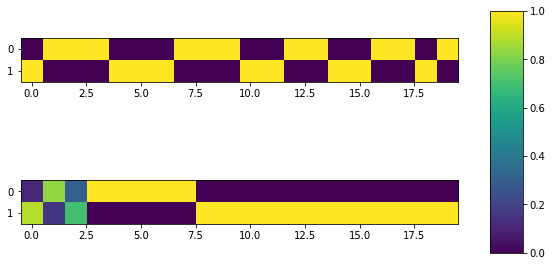

In [51]:
p = []
lbls = []
img = 4

for i in range(len(yTestOuts)):
    o = yTestOuts[i][img]
#     minn = np.min(o)
#     o = o-minn
#     maxx = np.max(o)
#     o = o/maxx
    p.append(o)
    lbls.append([0 for _ in range(NLBL)])
    lbls[-1][yTestLbls[i][img]] = 1

pp = np.asarray(p).transpose()
plbls = np.asarray(lbls).transpose()

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(9, 4.8))
# for ax in axes.flat:
#     im = ax.imshow(np.random.random((10,10)), vmin=0, vmax=1)
im = ax[0].imshow(plbls)
im = ax[1].imshow(pp, vmin=np.min(pp), vmax=np.max(pp))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

In [11]:
edges = []
edgefile = open("../edgelist","r")
for e in edgefile.readlines():
    edges.append(e.strip())

N = 400
L = 3.0
rho_ = [L*L*N/(float(x)*float(x)) for x in edges]

unlabeledfnames = ["edge"+str(x) for x in edges]
print unlabeledfnames

['edge40', 'edge35', 'edge30.0', 'edge29.2', 'edge28.6', 'edge27.9', 'edge27.4', 'edge26.8', 'edge26.3', 'edge25.8', 'edge25.4', 'edge24.9', 'edge24.5', 'edge24.1', 'edge23.7', 'edge23.4', 'edge23.0', 'edge22.7', 'edge22.4', 'edge22.1', 'edge21.8', 'edge21.5', 'edge21.2', 'edge21.0', 'edge20.7', 'edge20.5', 'edge20.2', 'edge20.0', 'edge19.8', 'edge19.6', 'edge19.4', 'edge19.2', 'edge18.9', 'edge18.5', 'edge18', 'edge17.5', 'edge17', 'edge16.75', 'edge16.5', 'edge16.25', 'edge16', 'edge15.75', 'edge15.5', 'edge15.25', 'edge15']
